In [ ]:
cd /content/drive/MyDrive/2021/HandsOnMachineLearning/main

/content/drive/MyDrive/2021/HandsOnMachineLearning/main


**3.1 MNIST**

In [ ]:
# MNIST 데이터 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


- mnist["data"]: 70,000개의 이미지에 각 784개의 특성 (28x28 픽셀 이미지)

- mnist["target"]: 각 data 이미지가 나타내는 숫자

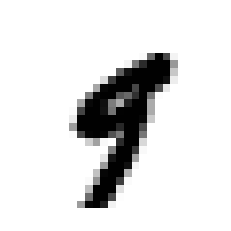

In [ ]:
# 예시 이미지 출력
import matplotlib
import matplotlib.pyplot as plt


some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28) # 28x28 픽셀 이미지

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

In [ ]:
y[36000]

'9'

In [ ]:
y = y.astype(np.uint8)

In [ ]:
# train set, test set 분리
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [ ]:
# shuffle train set
import numpy as np

shuffled_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffled_index], y_train[shuffled_index]

**3.2 이진 분류기 훈련**

In [ ]:
# 숫자 5인지 여부 구분하는 이진 분류기
y_train_5 = (y_train == 5) # 5는 True, 나머지는 False
y_test_5 = (y_test == 5)

In [ ]:
# 확률적 경사 하강법 (SGD)
from sklearn.linear_model import SGDClassifier

# 숫자 5에 대한 SGD 학습
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
sgd_clf.predict([some_digit])

array([False])

**3.3 성능 측정**

In [ ]:
# 3.3.1 교차검증을 사용한 정확도 측정
# K-fold validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.96825, 0.92995, 0.9605 ])

In [ ]:
# 모든 데이터를 '5가 아님'(0)로 분류하는 더미분류기 생성하여 정확도 측정
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9097 , 0.9103 , 0.90895])

In [ ]:
# 3.3.2 오차 행렬
# 예측값 생성
from sklearn.model_selection import cross_val_predict

# k-fold cross validataion으로 예측
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [ ]:
# confusion_matrix() 함수를 사용해서 오차 행렬 생성
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53043,  1536],
       [ 1290,  4131]])

# 오차 행렬
[[TN, FP],
 [FN, TP]]

In [ ]:
# 3.3.3 정밀도와 재현율
from sklearn.metrics import precision_score, recall_score

# 실제 train set label과 예측값 비교 -> 정밀도(precision), 재현율(recall) 계산
print('정밀도', precision_score(y_train_5, y_train_pred))
print('재현율', recall_score(y_train_5, y_train_pred))

정밀도 0.7289571201694018
재현율 0.7620365246264527


In [ ]:
# f1 score 계산
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7451298701298702

In [ ]:
# 결정함수, desicion function 임곗값 확인
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = -200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-335079.02537527]
[False]


threshold가 예측 점수보다 낮으므로 some_digit의 예측값은 True를 반환한다.

In [ ]:
# 임곗값 변경
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
# 적절한 임곗값을 구하는 방법

# 1. cross_val_predict()로 모든 샘플의 점수 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [ ]:
# 2. 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

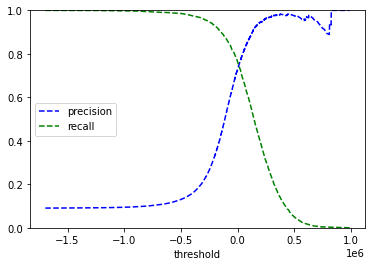

In [ ]:
# 3. matplotlib을 통해 정밀도와 재현율 그래프 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="precision")
  plt.plot(thresholds, recalls[:-1], "g--", label="recall")
  plt.xlabel("threshold")
  plt.legend(loc="center left")
  plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
# threshold를 70000으로 했을 때 예측
y_train_pred_90 = (y_scores > 70000)
print('precision: ', precision_score(y_train_5, y_train_pred_90))
print('recall: ', recall_score(y_train_5, y_train_pred_90))

precision:  0.8355704697986577
recall:  0.643054786939679


In [ ]:
# 3.3.5 ROC 곡선
# ROC 곡선은 민감도에 대한 '1 - 특이도' 그래프
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51667 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_

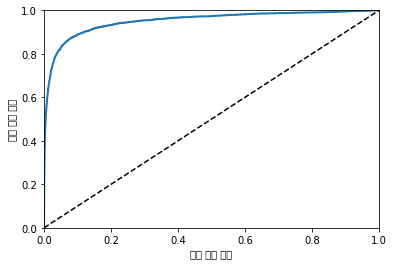

In [ ]:
# ROC 곡선 그래프
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('거짓 양성 비율')
  plt.ylabel('진짜 양성 비율')

plot_roc_curve(fpr, tpr)
plt.show()

# ROC 곡선
- 재현율이 높을수록 분류기가 만드는 거짓 양성이 늘어난다.
- 점선: 완전한 랜덤 분류기의 ROC 곡선
- 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야한다.
- AUC(곡전 아래의 면적)을 측정하여 분류기 비교 가능.

In [ ]:
# AUC 계산
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5, y_scores))

0.9512468973191276


In [ ]:
# RandomForestClassifier 모델을 훈련하여 비교
# RandomForestClassifier는 predict_proba() 메서드를 통해 클래스 결정
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51667 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_

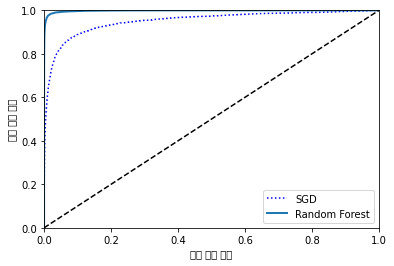

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

random forest가 SGD보다 더 좋은 성능을 보인다.

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983588130869459

**3.4 다중 분류**

In [ ]:
# SGDClassifier의 다중 분류 확인
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([3], dtype=uint8)

In [ ]:
# 10개 클래스 전체에 대해서 점수가 계산되어짐
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

[[-689424.78220521 -345583.18323824 -793598.41801496   -3218.25890861
  -153261.56751993 -268222.43822011 -736308.5883175  -206554.74293369
  -315131.82763439 -184609.05935887]]


In [ ]:
maxIdx = np.argmax(some_digit_scores)
print(sgd_clf.classes_)
print(sgd_clf.classes_[maxIdx])

[0 1 2 3 4 5 6 7 8 9]
3


In [ ]:
# OneVsOneClassifier - SGDClassifier 사용 예제
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
len(ovo_clf.estimators_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

[9]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


45

In [ ]:
# RandomForestClassifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9], dtype=uint8)

In [ ]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.  , 0.  , 0.08, 0.01, 0.  , 0.01, 0.  , 0.9 ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.8629, 0.8264, 0.8488])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.9101 , 0.90915, 0.91155])

**3.5 에러 분석**

In [ ]:
# 오차 행렬 분석
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5736,    4,   21,    9,    8,   47,   46,    9,   38,    5],
       [   1, 6483,   44,   26,    6,   47,    6,    9,  107,   13],
       [  53,   40, 5360,  102,   75,   22,   81,   54,  157,   14],
       [  52,   38,  148, 5362,    2,  212,   35,   59,  131,   92],
       [  23,   24,   44,    9, 5335,   10,   54,   30,   90,  223],
       [  76,   41,   40,  189,   70, 4591,  113,   29,  177,   95],
       [  39,   24,   49,    2,   38,   95, 5619,    7,   44,    1],
       [  26,   21,   69,   27,   49,    9,    5, 5807,   16,  236],
       [  55,  146,   78,  150,   13,  148,   54,   30, 5035,  142],
       [  46,   31,   27,   88,  149,   32,    2,  206,   80, 5288]])

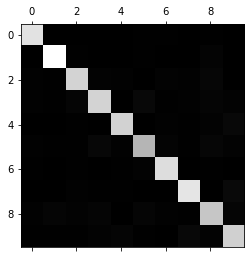

In [ ]:
# matshow() 사용하여 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 숫자 5가 다른 숫자들에 비해서 어두움
-> 데이터셋에 숫자 5의 데이터가 적거나, 다른 숫자만큼 잘 분류하지 못함

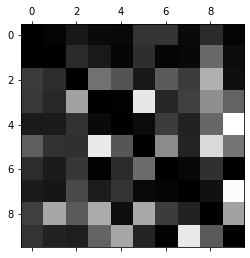

In [ ]:
# 오차행렬의 각 값을 클래스 별 이미지 개수로 나누어 에러 비율 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# 숫자 그림을 위한 추가 함수
import matplotlib as mpl

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

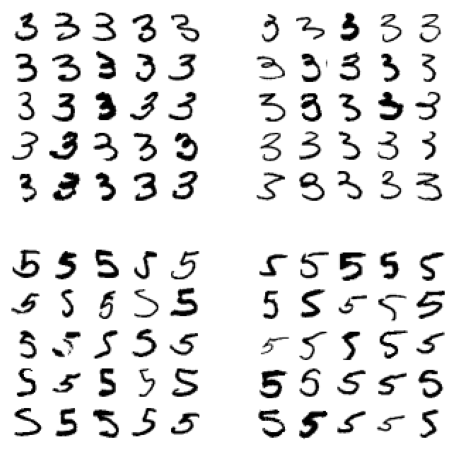

In [ ]:
# 3과 5를 잘못 구분한 데이터 샘플
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

**3.6 다중 레이블 분류**

In [ ]:
# knn classifier
from sklearn.neighbors import KNeighborsClassifier

# 첫번째 (y_train_large)는 7 이상의 큰 숫자인지 여부
# 두번쨰 (y_train_odd)는 홀수인지 여부
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [ ]:
# 모든 레이블에 대한 f1 score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

**3.7 다중 출력 분류**

In [ ]:
# 노이즈 추가
from numpy import random as rnd

# 노이즈가 추가된 이미지를 X_train으로 노이즈가 없는 이미지를 y_train으로 학습진행한다.
noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

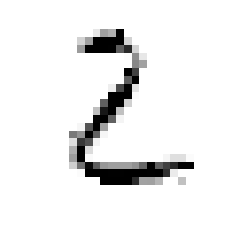

In [ ]:
# 노이즈 있는 이미지의 노이즈를 제거
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[1]])
plot_digit(clean_digit)

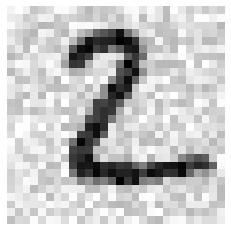

In [ ]:
plot_digit(X_test_mod[1])